# __*Use Darts to predict using past covariates data*__

## __*Install packages*__

### *The basis* for this file is "DARTS_past-covariates.ipynb"

In [1]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics


### __*Imports*__

In [68]:
from torchmetrics.regression import MeanSquaredError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [4]:
# !pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 11.2 MB/s eta 0:00:0000:0100:01
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=845938 sha256=2d677070f553b3403913505b8765be4ae7b7e139dc368d4ac6deb8db799f4b40
  Stored in directory: /home/javier/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee


### __*Import some example data from yfinance*__

In [6]:
# import yfinance as yf
# import pandas as pd

# # List of stock symbols
# stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

# # Set the start and end dates
# start_date = '2022-01-01'
# end_date = '2023-01-01'

# # Retrieve hourly data for each stock
# dfs = []
# for stock in stocks:
#     # Download data
#     stock_data = yf.download(stock, start=start_date, end=end_date, interval='1h')

#     # Select only the 'Close' column
#     stock_data = stock_data['Close']

#     # Rename the column to the stock symbol
#     stock_data = stock_data.rename(stock)

#     # Add to the list of DataFrames
#     dfs.append(stock_data)

# # Concatenate DataFrames along the columns
# df = pd.concat(dfs, axis=1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [40]:
df = pd.DataFrame(pd.read_csv('../raw_data/final_dataset.csv'))


In [41]:
df['date_time'] = pd.to_datetime(df['TimeStamp'])
df.drop(columns=['TimeStamp'], inplace=True)
df.set_index(['date_time'], inplace=True)
df.head()


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,TEMPERATURE_MORNING_C,...,WINDTEMP_MAX_C,UV_INDEX,TEMPERATURE_NIGHT_C,month_sin,month_cos,sunrise_time_sin,sunrise_time_cos,sunset_time_sin,sunset_time_cos,opinion
date_time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,...,0.0,1.0,2.0,0.5,0.866025,0.75471,-0.656059,-0.971342,-0.237686,0.0
2021-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-1.0,2.0,...,1.0,1.0,3.0,0.5,0.866025,0.75471,-0.656059,-0.972370,-0.233445,0.0
2021-01-02 08:20:00,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
2021-01-02 09:00:00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
2021-01-02 09:20:00,14.0,18.0,0.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0


In [43]:
df_sales = df[['traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat', 'baguette', 'banette', 'cereal_baguette']]
df_sales


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
date_time,,,,,,,
2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-02 08:20:00,0.0,0.0,0.0,3.0,1.0,0.0,0.0
2021-01-02 09:00:00,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2021-01-02 09:20:00,14.0,18.0,0.0,6.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...
2022-09-30 17:20:00,2.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-09-30 17:40:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-09-30 18:00:00,7.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df_sales[df_sales['traditional_baguette'] < 0]


,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
date_time,,,,,,,
2022-06-02 13:00:00,-2.0,0.0,0.0,0.0,2.0,0.0,0.0


In [48]:
df_sales.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15125 entries, 2021-01-01 00:00:00 to 2022-09-30 18:40:00
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traditional_baguette  15125 non-null  float64
 1   croissant             15125 non-null  float64
 2   coupe                 15125 non-null  float64
 3   pain_au_chocolat      15125 non-null  float64
 4   baguette              15125 non-null  float64
 5   banette               15125 non-null  float64
 6   cereal_baguette       15125 non-null  float64
dtypes: float64(7)
memory usage: 1.4 MB


### __*Convert the pandas dataframe in a darts timeseries object (we need a datetime index!)*__

In [55]:
# Convert the DataFrame to a Darts TimeSeries
# Index must be datetimeindex
timeseries = TimeSeries.from_dataframe(df_sales, fill_missing_dates=True, freq='20min', fillna_value=0)


In [56]:
timeseries.head()


<TimeSeries (DataArray) (date_time: 5, component: 7, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2021-01-01T01:20:00
  * component  (component) object 'traditional_baguette' ... 'cereal_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Scale the data using the Darts sklearn wrapper*__

In [57]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)


In [58]:
scaled_ts = ts_transformer.fit_transform(timeseries)
target_transformer = target_transformer.fit(timeseries['traditional_baguette'])


In [59]:
scaled_ts


<TimeSeries (DataArray) (date_time: 45921, component: 7, sample: 1)>
array([[[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
...
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.08      ],
        [0.05263158],
        [0.05263158],
        ...,
        [0.02222222],
        [0.1       ],
        [0.44444444]],

       [[0.09      ],
        [0.05263158],
        [0.10526316],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2022-09-30T18:40:00
  * component  (component) object 'traditional_baguette' ... 'cereal_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Handle missing values if you have*__
### __*(in this example, weekends are not available since we are dealing with stock markets)*__

In [60]:
from darts.utils.missing_values import fill_missing_values
scaled_ts = fill_missing_values(scaled_ts)
scaled_ts


<TimeSeries (DataArray) (date_time: 45921, component: 7, sample: 1)>
array([[[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
...
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.08      ],
        [0.05263158],
        [0.05263158],
        ...,
        [0.02222222],
        [0.1       ],
        [0.44444444]],

       [[0.09      ],
        [0.05263158],
        [0.10526316],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2022-09-30T18:40:00
  * component  (component) object 'traditional_baguette' ... 'cereal_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train Test Split*__

<Axes: xlabel='date_time'>

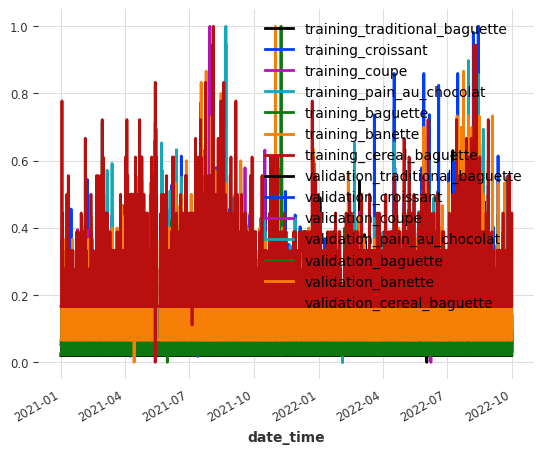

In [66]:
train, val = (scaled_ts).split_before(0.8)# (we standardize by dividing by 100 since Google Trends data tops out at 100 by default!)
train.plot(label="training")
val.plot(label="validation")


### __*Advanced multicovariate RNN training*__

### __*Setup Earlystopping and the train on GPU*__

In [67]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
es = EarlyStopping(
    monitor="val_loss",
    patience=20,
    min_delta=0.01,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [es],
                   "accelerator": "cpu"}


### __*Instanciate our model*__

In [69]:
# predict 7 days considering the latest 28 days

model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=28,
    output_chunk_length=7,
    dropout=0.2,
    torch_metrics=MeanSquaredError(),
    n_epochs=50,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)


In [70]:
train['traditional_baguette']


<TimeSeries (DataArray) (date_time: 36736, component: 1, sample: 1)>
array([[[0.02]],

       [[0.02]],

       [[0.02]],

       ...,

       [[0.02]],

       [[0.02]],

       [[0.02]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2021-01-01 ... 2022-05-26T05:00:00
  * component  (component) object 'traditional_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train the model*__

In [71]:
model_pastcov.fit(
    series=[train['traditional_baguette']],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val['traditional_baguette']],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True,
)


Epoch 20: 100%|██████████| 1147/1147 [00:37<00:00, 30.82it/s, train_loss=0.00131, val_loss=0.00221, val_MeanSquaredError=0.00221, train_MeanSquaredError=0.00107] 


BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.2, input_chunk_length=28, output_chunk_length=7, torch_metrics=MeanSquaredError(), n_epochs=50, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fe6f213d720>], 'accelerator': 'cpu'}, random_state=0)

### __*Do a prediction*__

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.99it/s]


<Axes: xlabel='date_time'>

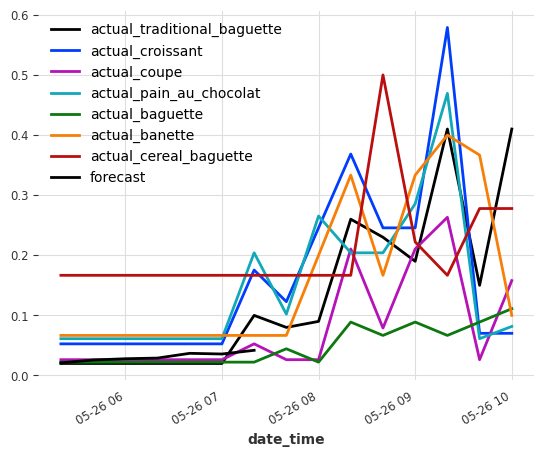

In [77]:
pred_cov = model_pastcov.predict(n=7,                        # n of days to predict
                                 series=train['traditional_baguette'][-28:],  # target input for prediction
                                 past_covariates=train[-28:]) # past-covariates input for prediction

val[:15].plot(label="actual")
pred_cov.plot(label="forecast")


### __*Check the metrics*__

In [73]:
# check the SMAPE error

smape(val['traditional_baguette'][:7], pred_cov)


42.57113127112717

### __*Extract the predictions as np array in the original scale*__

In [74]:
target_transformer.inverse_transform(pred_cov).values()


array([[0.11257169],
       [0.57552084],
       [0.78825923],
       [0.89885695],
       [1.68892593],
       [1.57526472],
       [2.19140996]])